# Entrenando un primer modelo

## Índice de Contenido

1. [Preparación del entorno y carga de datos](#1.-Preparación-del-entorno-y-carga-de-datos)
2. [Preparación de datos para el entrenamiento](#2.-Preparación-de-datos-para-el-entrenamiento)
    - [One-Hot Encoding y análisis de correlación respecto a variable objetivo](#2.1-One-hot-encoding-y-análisis-de-correlación-respecto-a-variable-objetivo)
    - [Estandarización y separación en datos de entrenamiento y prueba](#2.2-Estandarización-y-separación-en-datos-de-entrenamiento-y-prueba)
3. [Entrenamiento del modelo de regresión logística](#3.-Entrenamiento-del-modelo-de-regresión-logística)
4. [Evaluación del modelo mediante métricas de clasificación](#4.-Evaluación-del-modelo-mediante-métricas-de-clasificación)
5. [Análisis de la matriz de confusión](#5.-Análisis-de-la-matriz-de-confusión)
6. [Preparación y guardado de datos para análisis de equidad y posterior mitigación](#6.-Preparación-y-guardado-de-datos-para-análisis-de-equidad-y-posterior-mitigación)
7. [Resumen y conclusiones](#7.-Resumen-y-conclusiones)

## 1. Preparación del entorno y carga de datos

In [28]:
import pandas as pd
from tp_final_fairness_ML.utils.preprocessing import convertir_object_a_categ
import os 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from tp_final_fairness_ML.utils.plotting import graficar_matriz_de_confusion

# Carga de datos
ruta_archivo = os.path.join('..', 'data', 'processed', 'german_credit_data.csv')
g_credit_data = pd.read_csv(ruta_archivo)

# Conversión de columnas tipo objeto a categóricas para mejor manejo
g_credit_data = convertir_object_a_categ(g_credit_data)

In [29]:
# Vista general de los datos
print(f"Dimensiones del dataset: {g_credit_data.shape[0]} filas × {g_credit_data.shape[1]} columnas\n")
print("Primeras 5 filas:")
g_credit_data.head()

Dimensiones del dataset: 1000 filas × 23 columnas

Primeras 5 filas:


,checking_account,duration,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,other_debtors,...,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,target,genre,target_label
0,< 0 DM,6,critical account / other bank,radio/TV,1169,unknown / no account,>= 7 years,4,"male, single",none,...,none,own,2,skilled / official,1,"yes, registered",yes,1,male,low_risk
1,0 <= ... < 200 DM,48,paid duly till now,radio/TV,5951,< 100 DM,1 <= ... < 4 years,2,"female, div/sep/married",none,...,none,own,1,skilled / official,1,none,yes,2,female,high_risk
2,no account,12,critical account / other bank,education,2096,< 100 DM,4 <= ... < 7 years,2,"male, single",none,...,none,own,1,unskilled - resident,2,none,yes,1,male,low_risk
3,< 0 DM,42,paid duly till now,furniture/equipment,7882,< 100 DM,4 <= ... < 7 years,2,"male, single",guarantor,...,none,for free,1,skilled / official,2,none,yes,1,male,low_risk
4,< 0 DM,24,delay in past,car (new),4870,< 100 DM,1 <= ... < 4 years,3,"male, single",none,...,none,for free,2,skilled / official,2,none,yes,2,male,high_risk


In [30]:
# Información general sobre el dataset
g_credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   checking_account         1000 non-null   category
 1   duration                 1000 non-null   int64   
 2   credit_history           1000 non-null   category
 3   purpose                  1000 non-null   category
 4   credit_amount            1000 non-null   int64   
 5   savings_account          1000 non-null   category
 6   employment_since         1000 non-null   category
 7   installment_rate         1000 non-null   int64   
 8   personal_status_sex      1000 non-null   category
 9   other_debtors            1000 non-null   category
 10  residence_since          1000 non-null   int64   
 11  property                 1000 non-null   category
 12  age                      1000 non-null   int64   
 13  other_installment_plans  1000 non-null   category
 14  housing  

## 2. Preparación de datos para el entrenamiento

Llegamos a la prte de la preparación de datos para el entrenamiento de nuestro primer modelo. Entre los objetivos principales a lograr en esta sección tenemos:

* Llevar nuestros datos categóricos a un formato numérico mediante técnicas de encoding para poder usarlas en nuestro modelo.

* Realizar una **selección de variables** predictoras mediante el análisis de correlación respecto a la variable objetivo

* Sobre las variables seleccionadas **hacer una estandarización** de cara al entrenamiento del modelo.

* Separar los datos en conjuntos de entrenamiento y prueba.

### 2.1 One-Hot Encoding y análisis de correlación respecto a variable objetivo

Primero, aplicaremos **One-Hot Encoding** a nuestro conjunto de datos para convertir todas las variables categóricas en un formato completamente numérico. Sin embargo, antes de hacerlo, eliminaremos un par de columnas cuya inclusión en este proceso resultaría **redundante**: **target_label** y **personal_status_sex**. A continuación, explicamos las razones para su exclusión:

* **personal_status_sex** contiene información combinada sobre el género y el estado civil de los solicitantes. Durante el análisis exploratorio, ya resumimos esta información en una nueva columna llamada **genre**, que indica únicamente si el solicitante es hombre o mujer. Consideramos que el estado civil no es relevante para los objetivos de este proyecto, por lo que **genre** contiene toda la información pertinente. Mantener **personal_status_sex** sería, por lo tanto, redundante.

* **target_label** fue una columna auxiliar creada durante el análisis exploratorio para facilitar la interpretación de las clases objetivo. Sin embargo, su información ya está representada en la columna **target**, por lo que no es necesario conservarla ni transformarla.

Por último, es importante aclarar una modificación que realizaremos en la columna **target**, la cual actualmente codifica el riesgo crediticio como **1 para bajo riesgo** y **2 para alto riesgo**. Para simplificar el modelado y facilitar la interpretación de los resultados, convertiremos estos valores a **1 para bajo riesgo crediticio** y **0 para alto riesgo crediticio**, siguiendo la convención habitual en problemas de clasificación binaria. Con todo esto aclarado procedemos a realizar los cambios:

In [31]:
# Eliminación de columnas innecesarias
g_credit_data = g_credit_data.drop(columns=['target_label', 'personal_status_sex'])

# Cambio de valores en columna 'target'
g_credit_data['target'] = g_credit_data['target'].map({1: 1, 2: 0})

# One-Hot Encoding de variables categóricas
g_credit_data_dummies = pd.get_dummies(g_credit_data)
g_credit_data_dummies = g_credit_data_dummies.astype(int)

print(f"Dimensiones del dataset: {g_credit_data_dummies.shape[0]} filas × {g_credit_data_dummies.shape[1]} columnas\n")
print("Primeras 5 filas:")
display(g_credit_data_dummies.head())

Dimensiones del dataset: 1000 filas × 60 columnas

Primeras 5 filas:


,duration,credit_amount,installment_rate,residence_since,age,number_credits,people_liable,target,checking_account_0 <= ... < 200 DM,checking_account_< 0 DM,...,job_management / self-employed / qualified,job_skilled / official,job_unemployed / non-resident,job_unskilled - resident,telephone_none,"telephone_yes, registered",foreign_worker_no,foreign_worker_yes,genre_female,genre_male
0,6,1169,4,4,67,2,1,1,0,1,...,0,1,0,0,0,1,0,1,0,1
1,48,5951,2,2,22,1,1,0,1,0,...,0,1,0,0,1,0,0,1,1,0
2,12,2096,2,3,49,1,2,1,0,0,...,0,0,0,1,1,0,0,1,0,1
3,42,7882,2,4,45,1,2,1,0,1,...,0,1,0,0,1,0,0,1,0,1
4,24,4870,3,4,53,2,2,0,0,1,...,0,1,0,0,1,0,0,1,0,1


Ya con nuestros datos en un formato numérico podemos proceder con el **análisis de correlación** que nos ayudará a elegir variables predictoras para nuestro modelo. Procedemos a observar las correlaciones respecto a la variable objetivo:

In [32]:
correlaciones = g_credit_data_dummies.corr()['target'].sort_values(ascending=False)
print("Correlaciones con la variable 'target':")
print(correlaciones)

Correlaciones con la variable 'target':
target                                           1.000000
checking_account_no account                      0.322436
credit_history_critical account / other bank     0.181713
housing_own                                      0.134589
savings_account_unknown / no account             0.129238
property_real estate                             0.119300
other_installment_plans_none                     0.113285
purpose_radio/TV                                 0.106922
purpose_car (used)                               0.099791
age                                              0.091127
savings_account_>= 1000 DM                       0.085749
foreign_worker_no                                0.082079
employment_since_4 <= ... < 7 years              0.075980
genre_male                                       0.075493
savings_account_500 <= ... < 1000 DM             0.070954
employment_since_>= 7 years                      0.059733
other_debtors_guarantor         

Podemos ver en valores numéricos concretos cosas que **habíamos notado antes en el análisis exploratorio**: 

* La duración de un préstamo tiene una correlación negativa respecto a la variable objetivo, es decir que los solicitantes de alto riesgo solicitan préstamos de mayor duración.

* La presencia o ausencia de cuentas de ahorro/corriente tienen fuerte correlación en ambos sentidos con respecto a la variable objetivo.

Y así muchas otras relaciones observadas anteriormente en el análisis exploratorio podemos observar que aquí se cumplen.

Ahora con el objetivo de reducir el ruido y construir un modelo base más simple pero efectivo, aplicaremos un criterio básico de **selección de variables basado en la correlación** con la variable objetivo. En concreto, seleccionaremos aquellas variables que presenten una **correlación en valor absoluto mayor a 0.1** respecto de la variable **target**.

Este umbral fue elegido de manera pragmática: aunque no es alto, permite filtrar aquellas variables que tienen una **relación débil o inexistente con la variable objetivo**, sin ser demasiado restrictivo. De esta forma, eliminamos variables irrelevantes que podrían introducir ruido o redundancia en el modelo, al tiempo que conservamos aquellas que muestran al menos un **grado mínimo de asociación lineal** con el resultado que se desea predecir.
Procedemos a realizar dicha selección:

In [33]:
# Selección de variables con correlación significativa
variables_seleccionadas = correlaciones[abs(correlaciones) > 0.1].index.tolist()
variables_seleccionadas.append('genre_male')
variables_seleccionadas.remove('target')
                               
# Df para mostrar las variables seleccionadas junto con su correlacion
df_seleccionadas = pd.DataFrame(correlaciones[variables_seleccionadas])
df_seleccionadas = df_seleccionadas.reset_index()
df_seleccionadas.columns = ['variable', 'correlacion']
df_seleccionadas = df_seleccionadas.sort_values(by='correlacion', ascending=False)
print("Variables seleccionadas y su correlación con la variable 'target':")
df_seleccionadas

Variables seleccionadas y su correlación con la variable 'target':


,variable,correlacion
0,checking_account_no account,0.322436
1,credit_history_critical account / other bank,0.181713
2,housing_own,0.134589
3,savings_account_unknown / no account,0.129238
4,property_real estate,0.119300
5,other_installment_plans_none,0.113285
6,purpose_radio/TV,0.106922
16,genre_male,0.075493
7,employment_since_< 1 year,-0.106397
8,checking_account_0 <= ... < 200 DM,-0.119581


Como último comentario queríamos mencionar el hecho de que incluimos a la variable que registra el género entre las seleccionadas, por más que esta no tuviese una alta correlación entendemos que esta es la pieza central en el desarrollo del modelo. 

### 2.2 Estandarización y separación en datos de entrenamiento y prueba

Prepararemos los datos para el entrenamiento de nuestro modelo.Esto implica:

1. Separar variables predictoras (X) de la variable objetivo (y)
2. Dividir los datos en conjuntos de entrenamiento y prueba
3. Estandarizar las variables predictoras (X) de entrenamiento y prueba

In [34]:
# Separamos variables predictoras (X) y variable objetivo (y)
X = g_credit_data_dummies[variables_seleccionadas]
y = g_credit_data_dummies['target']
indices = X.index

# Dividimos en conjuntos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X.values, y.values, indices, test_size=0.2, random_state=42
)

# Estandarizamos las variables predictoras 
scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Mostramos las dimensiones de los conjuntos de entrenamiento y prueba
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Distribución de clases en el conjunto de entrenamiento: {np.bincount(y_train)}")
print(f"Distribución de clases en el conjunto de prueba: {np.bincount(y_test)}")

Dimensiones de X_train: (800, 17)
Dimensiones de X_test: (200, 17)
Distribución de clases en el conjunto de entrenamiento: [241 559]
Distribución de clases en el conjunto de prueba: [ 59 141]


## 3. Entrenamiento del modelo de regresión logística

Utilizaremos un modelo de regresión logística como nuestro modelo base debido a:

1. **Simplicidad e interpretabilidad**: La regresión logística es un modelo sencillo
   cuyos coeficientes pueden interpretarse directamente, facilitando el análisis de equidad.

2. **Adecuación al problema**: Al ser un problema de clasificación binaria (alto/bajo riesgo),
   la regresión logística es una opción natural y efectiva.

3. **Eficiencia computacional**: Requiere menos recursos y tiempo de entrenamiento
   que modelos más complejos, lo que es ideal para una primera iteración.

Procedemos al entrenamiento de este modelo:

In [35]:
from sklearn.linear_model import LogisticRegression

modelo = LogisticRegression(random_state=42, max_iter=1000, fit_intercept= True)
modelo.fit(X_train_scaled, y_train)

# Predicciones en el conjunto de prueba
y_pred_test = modelo.predict(X_test_scaled)

## 4. Evaluación del modelo mediante métricas de clasificación

Evaluaremos el desempeño del modelo utilizando métricas estándar de clasificación:

- **Precisión (Precision)**: Proporción de predicciones positivas que fueron correctas
- **Sensibilidad (Recall)**: Proporción de casos positivos reales que fueron correctamente identificados
- **F1-Score**: Media armónica de precisión y sensibilidad
- **Exactitud (Accuracy)**: Proporción total de predicciones correctas

Estas métricas nos darán una visión general de la calidad del modelo y su capacidad
para identificar correctamente tanto solicitantes de bajo como de alto riesgo.

In [36]:
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_test))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.66      0.42      0.52        59
           1       0.79      0.91      0.84       141

    accuracy                           0.77       200
   macro avg       0.72      0.67      0.68       200
weighted avg       0.75      0.77      0.75       200



### Interpretación de las métricas

- **Clase 1 (Bajo riesgo)**: El modelo muestra un buen desempeño identificando solicitantes de bajo riesgo:
  - Precisión: 0.79 - El 79% de los solicitantes clasificados como bajo riesgo efectivamente lo son.
  - Sensibilidad: 0.91 - El modelo identifica correctamente el 91% de los solicitantes de bajo riesgo.
  - F1-Score: 0.84 - Buen balance entre precisión y sensibilidad para esta clase.

- **Clase 0 (Alto riesgo)**: El desempeño es menor para identificar solicitantes de alto riesgo:
  - Precisión: 0.66 - El 66% de los solicitantes clasificados como alto riesgo realmente lo son.
  - Sensibilidad: 0.42 - El modelo solo identifica correctamente el 42% de los solicitantes de alto riesgo.
  - F1-Score: 0.52 - Desempeño bajo/moderado para esta clase.

- **Exactitud general**: 0.77 - El 77% de todas las predicciones son correctas.

Este desequilibrio en el desempeño entre clases podría atribuirse principalmente a la
distribución desbalanceada de las clases en los datos, donde hay más solicitantes de
bajo riesgo que de alto riesgo. Esta situación es común en problemas de crédito y
requiere atención especial desde la perspectiva de equidad.

## 5. Análisis de la matriz de confusión

La matriz de confusión nos permitirá visualizar en detalle los aciertos y errores del modelo,
así como entender los diferentes tipos de errores (falsos positivos y falsos negativos) y su
impacto en términos de equidad y toma de decisiones.

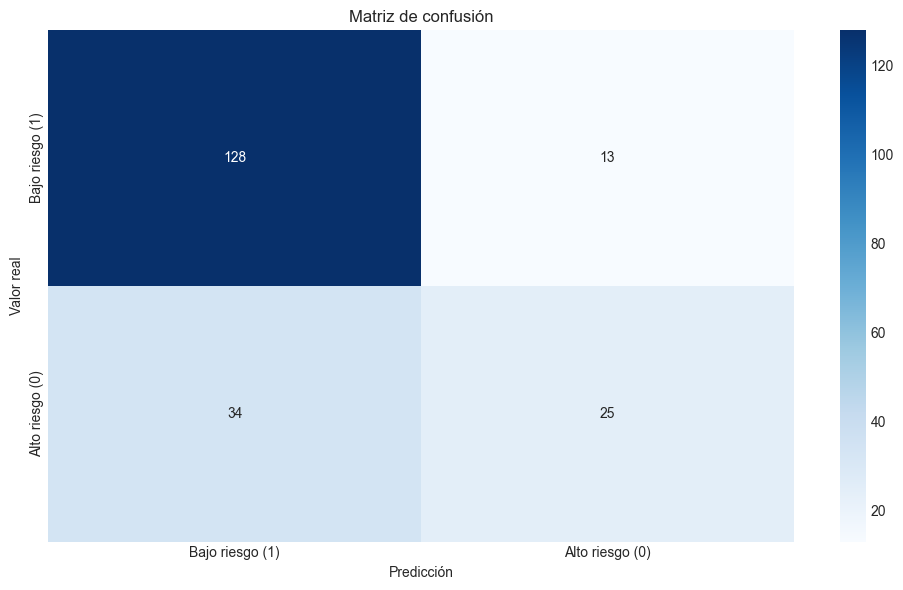

In [37]:
graficar_matriz_de_confusion(y_test, y_pred_test)

### Interpretación de la matriz de confusión

Para interpretar correctamente la matriz, consideremos:

- **Verdaderos positivos (TP)**: 128 solicitantes fueron correctamente clasificados como de bajo riesgo.
- **Falsos negativos (FN)**: 13 solicitantes de bajo riesgo fueron incorrectamente clasificados como de alto riesgo.
- **Falsos positivos (FP)**: 34 solicitantes de alto riesgo fueron incorrectamente clasificados como de bajo riesgo.
- **Verdaderos negativos (TN)**: 25 solicitantes fueron correctamente clasificados como de alto riesgo.

**Implicaciones de los errores**:

1. **Falsos positivos (34)**: Este tipo de error es particularmente problemático para instituciones financieras, ya que implica otorgar préstamos a personas que realmente son de alto riesgo, lo que podría resultar en pérdidas financieras.

2. **Falsos negativos (13)**: Aunque menos costoso desde la perspectiva financiera, este error implica negar préstamos a personas que realmente son de bajo riesgo, lo que representa un problema de equidad y acceso a servicios financieros.

El balance entre estos tipos de errores es fundamental para garantizar tanto la salud financiera de la institución como la equidad en el acceso al crédito para diferentes grupos demográficos.

## 6. Preparación y guardado de datos para análisis de equidad y posterior mitigación

Para realizar un análisis de equidad por género, necesitamos combinar nuestras predicciones
con la información de género de los solicitantes. Esto nos permitirá evaluar si el modelo
presenta sesgos algorítmicos que afecten desproporcionadamente a algún grupo.

Crearemos un nuevo conjunto de datos que contenga:
- Las etiquetas reales **y_test**
- Las predicciones del modelo **y_pred_test**
- El género de cada solicitante

In [38]:
ruta_datos_procesados = os.path.join('..', 'data', 'processed', 'german_credit_data.csv')
g_credit_data = pd.read_csv(ruta_datos_procesados)

df_genero_eval = pd.DataFrame({
    'y_test': y_test,
    'y_pred_test': y_pred_test,
    'genre': g_credit_data.loc[idx_test, 'genre']
})

print("Primeras filas del dataframe para análisis de equidad:")
display(df_genero_eval.head())

ruta_guardado = os.path.join('..', 'data', 'processed', 'df_genero_eval.csv')
df_genero_eval.to_csv(ruta_guardado, index=False)
print(f"Datos guardados en: {ruta_guardado}")

Primeras filas del dataframe para análisis de equidad:


,y_test,y_pred_test,genre
521,0,1,female
737,1,1,male
740,1,0,male
660,1,1,male
411,1,1,male


Datos guardados en: ..\data\processed\df_genero_eval.csv


También guardaremos los conjuntos de datos de entrenamiento y de prueba, esto con el propósito de usarlos en la posterior 
aplicación de técnicas de mitigación sobre el modelo base:

In [39]:
# Convertimos los conjuntos de entrenamiento y prueba a DataFrames para guardarlos
X_train_df = pd.DataFrame(X_train, columns=variables_seleccionadas)
X_test_df = pd.DataFrame(X_test, columns=variables_seleccionadas)
y_train_df = pd.DataFrame(y_train, columns=['target'])
y_test_df = pd.DataFrame(y_test, columns=['target'])

# Definimos las rutas para guardar los conjuntos de entrenamiento y prueba
ruta_X_train = os.path.join('..', 'data', 'processed', 'X_train.csv')
ruta_X_test = os.path.join('..', 'data', 'processed', 'X_test.csv')
ruta_y_train = os.path.join('..', 'data', 'processed', 'y_train.csv')
ruta_y_test = os.path.join('..', 'data', 'processed', 'y_test.csv')

# Guardamos los conjuntos de entrenamiento y prueba en archivos CSV
X_train_df.to_csv(ruta_X_train, index=False)
X_test_df.to_csv(ruta_X_test, index=False)
y_train_df.to_csv(ruta_y_train, index=False)
y_test_df.to_csv(ruta_y_test, index=False)

print(f"Conjuntos de entrenamiento y prueba guardados en:")
print(f" - {ruta_X_train}")
print(f" - {ruta_X_test}")
print(f" - {ruta_y_train}")
print(f" - {ruta_y_test}")

Conjuntos de entrenamiento y prueba guardados en:
 - ..\data\processed\X_train.csv
 - ..\data\processed\X_test.csv
 - ..\data\processed\y_train.csv
 - ..\data\processed\y_test.csv


## 7. Resumen y conclusiones

En este notebook hemos completado las siguientes tareas:

1. **Carga y preparación de datos**: Importamos el conjunto de datos German Credit y aplicamos un One hot encoding para poder entrenar un modelo usando también a las variables categóricas.

2. **Selección de features**: Una vez hecho el One-Hot Encoding elegimos las columnas que mostraron mayor correlación con la variable objetivo, eliminando así gran parte del ruido.

3. **Entrenamiento del modelo**: Implementamos un modelo de regresión logística para predecir el riesgo crediticio de un solicitante.

4. **Evaluación de desempeño**: Analizamos las métricas de clasificación y la matriz de confusión para entender el comportamiento del modelo.

5. **Preparación y guardado de datos para análisis de equidad y posterior mitigación**: Generamos un conjunto de datos que incluye las predicciones y el género de los solicitantes, además guardamos los conjuntos de datos de entrenamiento y prueba para usarlo en posteriores modelos mitigados que desarrollemos.

Observamos que el modelo tiene un buen desempeño general (77% de exactitud), pero muestra diferencias significativas en su capacidad para identificar correctamente las dos clases: es mejor identificando solicitantes de bajo riesgo (91% de sensibilidad) que solicitantes de alto riesgo (42% de sensibilidad).